https://github.com/OATESE/bee2041_p1_g


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import random as rd
import numpy as np

# The Doctor Strikes Back

We are now going to change the behaviour of the agents. We will add a new state where agents are immunised. When an agent recovered they will stay in the `Recovered` state but they can be infected again as if they were in the Susceptible state. We will do this by allowing `Recovered` agents to be infected by their neighbors. An agent that is immunised can never be infected. During the initialisation we will immunise a certain percent of the agents.

In [2]:
# simulation parameters

nb_agents = 100
max_iterations = 10

In [3]:
# model parameters

## infection

probInfection = 0.2
probRecovery = 0.2
probImmunity= 0.2 #
probInfectionInit = 0.1
probImmunityInit = 0.1 #some start immunised, so never be infected
probInfectionResidual = 0.0 #not allowing agents to be infected randomly other than through their infected neighbours.

randomInitialInfection=True #specifying that nodes will be chosen randomly to start in the state Infected at the start of the simulation.
randomInitialVaccination=True
immunityPeriod=3

In [4]:
## communication structure


# model states

systemState = None
nextSystemState = None

agSusceptible = 0
agInfected = 1
agRecovered = 2 #agents who get recovered also can become immunised with prob immunity or susceptible again but keep as recovered to differentiate first and second time infected.
agImmunised= 3 #new state, probability of being immunised after recover

In [5]:
# helper functions
def test_state(n,value):
    global systemState

    return systemState.nodes[n]['state'] == value

In [6]:
# model dynamics

def init(network, nb_agents, netParam, probInfectionInit, probImmunityInit, randomInitialVaccination, immunityPeriod):
    global systemState

    # generate communication structure
    if network == nx.erdos_renyi_graph:
        systemState = nx.erdos_renyi_graph(nb_agents, netParam)
    elif network == nx.barabasi_albert_graph:
        systemState = nx.barabasi_albert_graph(nb_agents, netParam)
    else:
        raise ValueError("Invalid network type specified.")

    # init agents' states #infected ones first
    if randomInitialInfection: #first way to start where agents are chosen randomly
        # random infection
        for a in systemState.nodes():
            if rd.random() < probInfectionInit: #10% of agents get randomly infected
                systemState.nodes[a]['state'] = agInfected
                #print("Oh no, agent", a, "got infected!")
            else:
                systemState.nodes[a]['state'] = agSusceptible #if not then susceptible

    if randomInitialVaccination:
        for a in systemState.nodes():
            if systemState.nodes[a]['state'] == agSusceptible:
                if rd.random() < probImmunityInit: #some get immunised
                    systemState.nodes[a]['state'] = agImmunised
                    systemState.nodes[a]['rem_immunity_period'] = immunityPeriod
                    #print("Agent", a, "is immunised. Such a lucky guy!")

    else: #second way to start: agents are targeted immunised
        # targetted vaccination

        # Get the measure (map node > value)
        measure = dict(nx.degree(systemState))

        # Sort the nodes accordingly
        measure = sorted(measure.items(), key=lambda x: x[1], reverse=True)

        # Retain only the nodes (discard the value)
        measure = [x[0] for x in measure]

        #nb_agents_to_infect = int(probInfectionInit * float(nb_agents))
        nb_agents_to_immunise = int((sum([1 for a in systemState.nodes() if systemState.nodes[a]['state'] == agSusceptible]))* probImmunityInit)#changed to make only out of the susceptible ones

        # Immunize the first N susceptible nodes with the highest degree
        # Filter susceptible agents
        susceptible_agents = [node for node in measure if systemState.nodes[node]['state'] == agSusceptible]

        # Immunize the first N susceptible nodes with the highest degree
        for node in susceptible_agents[:nb_agents_to_immunise]:
            systemState.nodes[node]['state'] = agImmunised
            systemState.nodes[node]['rem_immunity_period'] = immunityPeriod


In [7]:
def step(probInfection,probImmunity,probRecovery):
    global systemState

    # copy current network structure and agent s'states
    nextSystemState = systemState.copy()

    # determine next agents' state
    for a in systemState.nodes():
        # if infected
        if test_state(a,agInfected):
            # first try to recover
            if rd.random() < probRecovery:
                nextSystemState.nodes[a]['state'] = agRecovered
                #print("Good news, agent", a, "is feeling better!") #recovered but not immunised so can still get infected
            elif rd.random() < probImmunity:
                nextSystemState.nodes[a]['state'] = agImmunised
                nextSystemState.nodes[a]['rem_immunity_period'] = immunityPeriod# will be immunised
                #print("Good news, agent", a, "is feeling better and getting Immunised!")
            # if not try to propagage virus
            else:#if it doesnt recover it will try to infect its neighbour
                for n in systemState.neighbors(a):
                    # if recovered, try to infect (again)
                    if test_state(n,agRecovered): #if neighbour is recovered they can still be infected (different from before)
                        if rd.random() < probInfection:
                            nextSystemState.nodes[n]['state'] = agInfected
                            #print("Oh no, agent", n, "got infected AGAIN!")
                    # otherwise, try to infect
                    elif test_state(n,agSusceptible): #if not recovered but susceptible try to infect it again
                        if rd.random() < probInfection:
                            nextSystemState.nodes[n]['state'] = agInfected
                            #print("Oh no, agent", n, "got infected!")

        #if immunized
        elif test_state(a, agImmunised):
            # decrease immunity period 1
            nextSystemState.nodes[a]['rem_immunity_period'] -= 1

            # change state if immunity period reach 0
            if nextSystemState.nodes[a]['rem_immunity_period'] == 0:
                nextSystemState.nodes[a]['state'] = agSusceptible

        # residual infection
        #if test_state(a,agSusceptible) or test_state(a,agRecovered):
        #    if rd.random() < probInfectionResidual:
        #        if test_state(a,agRecovered):
        #            print("Oh no, agent", a, "got infected AGAIN!")
        #        else:
        #            print("Oh no, agent", a, "got infected!")
        #        nextSystemState.nodes[a]['state'] = agInfected

    # synchronous transition to next state
    systemState = nextSystemState

In [8]:
statS = []
statI = []
statR = []
statM = [] #new list to collect number of immunised agents

def collect_statistics():
    global systemState

    nbS = 0
    nbI = 0
    nbR = 0
    nbM = 0
    for a in systemState.nodes():
        if test_state(a,agSusceptible):
            nbS = nbS + 1
        if test_state(a,agInfected):
            nbI = nbI + 1
        if test_state(a,agRecovered):
            nbR = nbR + 1
        if test_state(a,agImmunised):
            nbM = nbM + 1
    statS.append(nbS)
    statI.append(nbI)
    statR.append(nbR)
    statM.append(nbM)
    return statS,statI,statM

In [9]:
def display_statistics():
    plt.plot(statS,label="S", color="b")
    plt.plot(statI,label="I", color="r")
    plt.plot(statR,label="R", color="g")
    plt.plot(statM,label="M", color="y")

    plt.legend()
    plt.show()

In [10]:
def draw():
    global systemState

    list_colors = []
    for a in systemState.nodes():
        if test_state(a,agSusceptible):
            list_colors.append("b")
        if test_state(a,agInfected):
            list_colors.append("r")
        if test_state(a,agRecovered):
            list_colors.append("g")
        if test_state(a,agImmunised):
            list_colors.append("y")

    nx.draw(systemState, node_color = list_colors)
    plt.show()

In [11]:
def run_simulation(nba=100,
                   maxIter=10,
                   probI=0.2,
                   probR=0.2,
                   probV=0.0,
                   probI_init=0.1,
                   probV_init=0.1,
                   vRandom=True,
                   immPeriod=3,
                   network=nx.erdos_renyi_graph,
                   netParam=0.1,
                   rep=10):

    results = []  # Store the results of each repetition
    for r in range(rep):
        #print("starting simulation")
        init(network=network,
             nb_agents=nba,
             netParam=netParam,
             probInfectionInit=probI_init,
             probImmunityInit=probV_init,
             randomInitialVaccination=vRandom,
             immunityPeriod=immPeriod,
             )
        #draw()
        i = 0
        while i < maxIter:
            #print("== round", i)
            step(probInfection=probI,
                 probImmunity=probV,
                 probRecovery=probR)
            #draw()
            statS, statI, statM = collect_statistics()
            if statI[-1] == 0:  # Check the last element in statI
                break
            i = i + 1
        #print("the end")
        # draw()
        #display_statistics()
        results.append(statS[-1] + statM[-1])  # Append the sum of the last elements of statS and statM

    mean_result = sum(results) / len(results)
    percentage = (mean_result / nba) * 100
    #print(percentage)
    return percentage

if __name__ == "__main__":
    run_simulation()


In [12]:
# 3 different lines (scenarios)
scenarios = [
    {"label": "Control", "probV_init": 0, "immPeriod": 3, "color": "red"},
    {"label": "3-timestep, 40% immunity", "probV_init": 0.4, "immPeriod": 3, "color": "lightblue"},
    {"label": "6-timestep, 20% immunity", "probV_init": 0.2, "immPeriod": 6, "color": "blue"},]

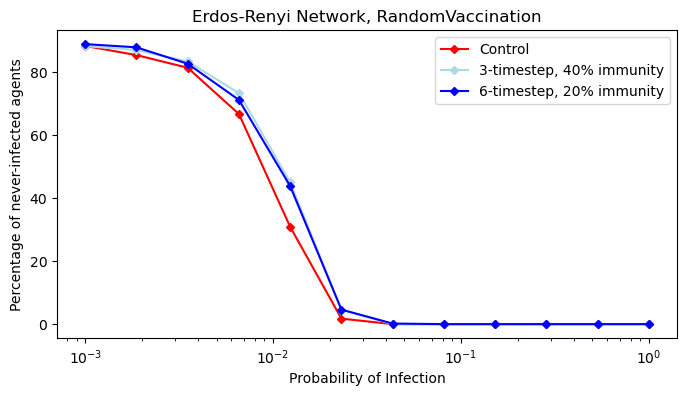

In [13]:
#  fig 1
plt.figure(figsize=(8,4))
for scenario in scenarios:
    y = []
    x_values = np.logspace(-3, 0, 12)  # Create a list of probI values
    for probI in x_values:
        result = run_simulation(
            probI=probI,
            nba=500,
            probV_init=scenario["probV_init"],
            immPeriod=scenario["immPeriod"],
        )
        y.append(result)
    plt.plot(x_values, y, label=scenario["label"], color=scenario["color"], marker='D',markersize = 4)

plt.xscale("log")
plt.xlabel('Probability of Infection')
plt.ylabel("Percentage of never-infected agents")
plt.legend()
plt.title("Erdos-Renyi Network, RandomVaccination")
plt.show()


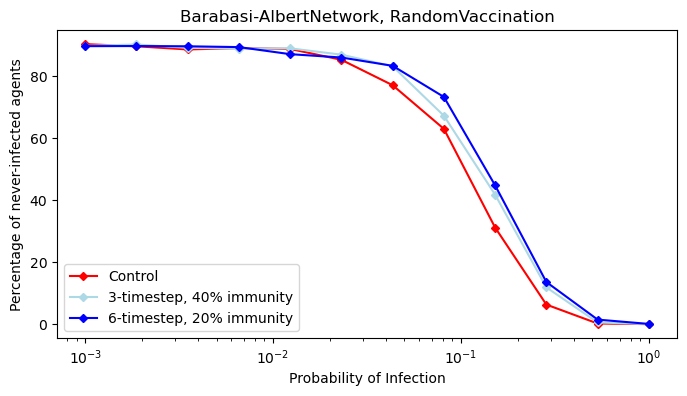

In [14]:
# fig 2
plt.figure(figsize=(8,4))
for scenario in scenarios:
    y = []
    x_values = np.logspace(-3, 0, 12)  # Create a list of probI values
    for probI in x_values:
        result = run_simulation(
            probI=probI,
            nba=500,
            probV_init=scenario["probV_init"],
            immPeriod=scenario["immPeriod"],
            network=nx.barabasi_albert_graph,
            netParam=2
        )
        y.append(result)
    plt.plot(x_values, y, label=scenario["label"], color=scenario["color"], marker='D',markersize = 4)

plt.xscale("log")
plt.xlabel('Probability of Infection')
plt.ylabel("Percentage of never-infected agents")
plt.legend()
plt.title("Barabasi-AlbertNetwork, RandomVaccination")
plt.show()

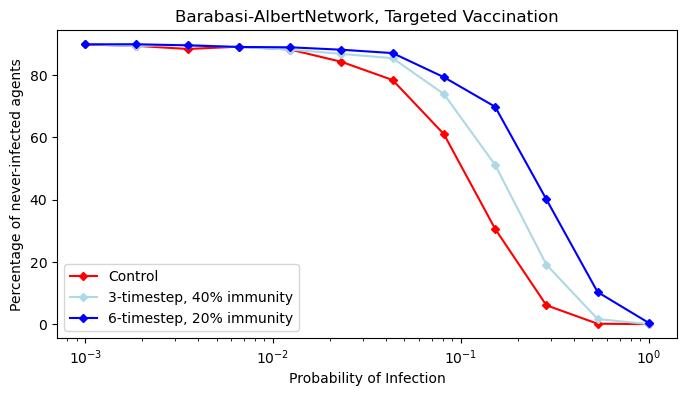

In [15]:
#fig 3
plt.figure(figsize=(8,4))
for scenario in scenarios:
    y = []
    x_values = np.logspace(-3, 0, 12)  # Create a list of probI values
    for probI in x_values:
        result = run_simulation(
            probI=probI,
            nba=500,
            probV_init=scenario["probV_init"],
            immPeriod=scenario["immPeriod"],
            network=nx.barabasi_albert_graph,
            netParam=2,
            vRandom = False
        )
        y.append(result)
    plt.plot(x_values, y, label=scenario["label"], color=scenario["color"], marker='D',markersize = 4)

plt.xscale("log")
plt.xlabel('Probability of Infection')
plt.ylabel("Percentage of never-infected agents")
plt.legend()
plt.title("Barabasi-AlbertNetwork, Targeted Vaccination")
plt.show()

In both types of networks there is a positive effect on reducing the spread of the infection (in terms of percentage of never infected agents) when implementing either vaccination strategy (cheap or expensive) in comparison to the control when there is no vaccination strategy.

In the erdos reyni, random vaccination, the virus spreads at a much faster rate (with lower infection probabilities) and at a certain probability of infection all agents will be at some point infected by the end of the simulation regardless of the vaccination strategy.

the third graph, which is the Barabasi-Albert network with targeted vaccination differs quite a bit from the other two graphs including the Barabasi-albert random vaccination approach. this is because the target vaccination approach focuses on immunizing the nodes with the most degrees(connections) which would be more likely to spread the infection. By targeting these agents, the spread of the infection is best controlled leading to higher proportions of never infected agents.